# Validazione Incrociata Leave-One-Out {#sec-loo}

**Prerequisiti**

**Concetti e competenze chiave**

- Comprendere il concetto di validazione incrociata Leave-One-Out.
- Calcolare LOO-CV usando ArviZ.
- Usare LOO-CV nel confronto tra modelli.
- Comprendere e calcolare i valori diagnostici Pareto $k$.

**Preparazione del Notebook**

In [2]:
import os
import itertools
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy import stats
import pingouin as pg
import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
import warnings

warnings.simplefilter(action="ignore")

In [3]:
seed: int = sum(map(ord, "stan_loo"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(
    home_directory, '_repositories', 'psicometria')

## Introduzione {.unnumbered}

La capacità di generalizzazione di un modello statistico, ossia la sua abilità di fare previsioni accurate su nuovi dati, è un aspetto cruciale nella modellazione statistica (per uno studio recente, si veda, ad esempio, @chekroud2024illusory). Per valutare quantitativamente questa capacità, sono state sviluppate diverse metriche. Tra queste, la Densità Predittiva Logaritmica Attesa (Expected Log Predictive Density, ELPD) è particolarmente apprezzata per la sua efficacia. L'ELPD fornisce una stima diretta della capacità di un modello di prevedere nuovi dati, rendendola un indicatore fondamentale della sua capacità di generalizzazione.

Uno dei metodi più efficaci e comunemente utilizzati per stimare l'ELPD è la validazione incrociata Leave-One-Out (LOO-CV), come discusso nella sezione @sec-kl-elpd. Questo metodo simula uno scenario di previsione su nuovi dati escludendo sistematicamente ogni singola osservazione dal set di addestramento e valutando la capacità del modello di predire l'osservazione esclusa. In questo capitolo, approfondiremo la metodologia LOO-CV e mostreremo come essa venga applicata per valutare e selezionare modelli statistici in base alla loro capacità di generalizzare.

Negli esempio successivi, mostreremo come applicare questi concetti utilizzando `cmdstan`. Questo approccio pratico illustrerà l'intero processo di selezione e valutazione del modello, fornendo un metodo robusto per scegliere il modello più appropriato, tenendo conto sia della sua capacità predittiva che della sua adeguatezza ai dati osservati.

## Il Problema del Sovra-adattamento

Uno dei problemi più comuni che emerge durante la costruzione di un modello statistico è il sovra-adattamento, o overfitting. Questo fenomeno si verifica quando un modello si adatta eccessivamente ai dati di addestramento, catturando non solo le tendenze generali, ma anche le fluttuazioni casuali e gli errori presenti nei dati.

### Perché il Sovra-adattamento è un Problema?

Un modello sovra-adattato può mostrare prestazioni eccellenti sui dati di addestramento, ma tende a fallire quando applicato a nuovi dati. In altre parole, il modello "impara a memoria" i dati di addestramento piuttosto che apprendere le regole generali che li governano. Questo compromette la sua capacità di generalizzazione, rendendolo inaffidabile per previsioni future.

Per evitare il sovra-adattamento, è necessario bilanciare la capacità del modello di adattarsi ai dati di addestramento con la sua capacità di generalizzare a nuovi dati. Questo equilibrio è noto come il "trade-off" tra bias e varianza.

### Tecniche di Validazione

Per prevenire il sovra-adattamento, si utilizzano tecniche di validazione, che permettono di valutare quanto bene un modello si comporterà su dati non visti. Una delle tecniche più importanti in questo contesto è la *validazione incrociata* (cross-validation).

### Validazione Incrociata (Cross-Validation)

La validazione incrociata è una metodologia che consente di testare il modello su dati che non ha mai visto durante l'addestramento. Esistono diverse varianti di validazione incrociata, tra cui:

1. **K-fold cross-validation**:

   - I dati vengono divisi in K gruppi (o "fold").
   - Si addestra il modello su K-1 gruppi e si testa sull'ultimo gruppo.
   - Questo processo viene ripetuto K volte, utilizzando ogni volta un gruppo diverso per il test.
   - I risultati vengono poi mediati per ottenere una stima complessiva della performance del modello.

   Ad esempio, con K = 5, i dati vengono suddivisi in 5 parti; il modello viene addestrato su 4 parti e testato sulla quinta, ripetendo il processo 5 volte.

2. **Leave-one-out cross-validation (LOO-CV)**:

   - È una forma estrema di K-fold in cui K è pari al numero totale di osservazioni.
   - Ogni volta, si esclude una singola osservazione dal set di addestramento e si utilizza il modello per prevedere quell'osservazione.
   - Questo processo viene ripetuto per ogni osservazione nel dataset.

   Il LOO-CV è particolarmente utile per ottenere una stima precisa della capacità del modello di generalizzare, ma può essere computazionalmente intensivo.

Queste tecniche di validazione forniscono una misura accurata della capacità di un modello di generalizzare su nuovi dati.

## Applicazioni Pratiche

Nel contesto dell'inferenza bayesiana, la selezione del modello si basa principalmente sul confronto delle stime dell'ELPD ottenute tramite la Leave-One-Out Cross-Validation (LOO-CV). Questo processo può essere implementato in modo efficiente utilizzando le funzioni del pacchetto ArviZ.

È importante notare che l'affidabilità di questi confronti dipende dalla qualità dei dati e dall'adeguatezza dei modelli. Per ottenere valutazioni accurate, è essenziale che i modelli si adattino in modo appropriato ai dati disponibili. Un aspetto cruciale di questa valutazione è rappresentato dal calcolo dei valori diagnostici di Pareto $k$. 

## Valori Diagnostici Pareto $k$

I valori diagnostici di Pareto $k$ sono fondamentali per valutare la stabilità e l'affidabilità delle stime ottenute tramite la Leave-One-Out Cross-Validation (LOO-CV). In particolare, essi misurano l'influenza di singoli punti dati sulle stime del modello. Valori di $k$ elevati possono indicare che alcune osservazioni hanno un'influenza eccessiva, il che può compromettere la validità delle stime fornite dalla LOO-CV.

Il valore di Pareto $k$ fornisce un'indicazione dell'affidabilità della stima:

- $k < 0.5$: L'approssimazione è eccellente e l'errore nella stima dell'ELPD è trascurabile.
- $0.5 \leq k < 0.7$: L'approssimazione è accettabile, ma potrebbe essere utile esaminare più attentamente il modello e i dati.
- $0.7 \leq k < 1$: L'approssimazione diventa mediocre, rendendo i risultati della LOO-CV meno affidabili e potenzialmente inadeguati.
- $k \geq 1$: Un valore così elevato segnala un'approssimazione inadeguata, suggerendo che i risultati ottenuti potrebbero essere significativamente distorti, evidenziando problemi nel modello o nella metodologia.

Il valore di Pareto $k$ si basa sulla distribuzione di Pareto per valutare le discrepanze nelle log-verosimiglianze, cioè le differenze tra la log-verosimiglianza calcolata escludendo un dato e quella ottenuta utilizzando l'intero dataset. Valori alti di $k$ indicano code più pesanti del previsto nella distribuzione delle discrepanze, suggerendo che l'approssimazione potrebbe non essere accurata.

In sintesi, i valori di Pareto $k$ forniscono un indicatore chiave dell'accuratezza dell'approssimazione fornita dalla LOO-CV e aiutano a identificare eventuali problemi nel modello statistico o nella metodologia utilizzata.

::: {#exm-}

Per fare un esempio relativo al calcolo dei valore di Pareto $k$, generiamo un set di dati artificiali seguendo una distribuzione normale con una media di 5 e una deviazione standard di 2. Scegliamo una dimensione del campione di 100.

In [4]:
y = np.random.normal(loc=5, scale=2, size=100)
print(y[0:10])

[ 3.55144618  7.24614848  3.17600124 10.48005661  0.24404946  3.9483861
  3.47263944  1.50310884  4.7620044   6.45235628]


Inseriamo i dati in un dizionario nel formato atteso da Stan.

In [7]:
stan_data = {"N": len(y), "y": y}

Adattiamo ai dati un modello normale stimando la media (`mu`) e la deviazione standard (`sigma`) del modello attraverso il campionamento MCMC.

In [8]:
stan_file = os.path.join(
    project_directory, 'stan', 'gaussian-mod-log-lik.stan')

model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=0> N;
  vector[N] y;
}
parameters {
  real mu;
  real<lower=0> sigma;
}
model {
  // Priors
  mu ~ normal(5, 2);         // Prior for mu, centered around the known mean with some uncertainty
  sigma ~ normal(0, 2);      // Half-normal prior for sigma (implying positive values)
  
  // Likelihood
  y ~ normal(mu, sigma);
}
generated quantities {
  vector[N] log_lik;
  for (n in 1:N)
    log_lik[n] = normal_lpdf(y[n] | mu, sigma);
}



Eseguiamo il campionamento.

In [9]:
fit = model.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False, 
    show_console=False
)

Esaminiamo le distribuzioni a posteriori.

In [10]:
az.summary(fit, var_names=['mu', 'sigma'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.73,0.21,4.33,5.12,0.0,0.0,6461.15,5090.21,1.0
sigma,2.12,0.15,1.84,2.40,0.0,0.0,6389.72,5247.38,1.0


Convertiamo l'oggetto creato da cmdstanpy nella classe InferenceData richiesta da ArviZ:

In [11]:
fit_az = az.from_cmdstanpy(posterior=fit)

Eseguiamo la LOO-CV usando ArviZ:

In [12]:
loo_result = az.loo(fit_az)
print(loo_result)

Computed from 8000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -217.79     6.76
p_loo        1.92        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



Poiché il modello si adatta bene a questi dati, tutti i valori di Pareto $k$ sono molto bassi, indicando che nessuna osservazione ha un'influenza eccessiva sulle stime del modello. Di conseguenza, non vi è alcuna evidenza che la stima dell'ELPD, che in questo caso è pari a -217.79, possa essere distorta. Questo suggerisce che la stima è affidabile e rappresenta accuratamente la capacità predittiva del modello.

:::

## Il Ruolo dell'ELPD nella Valutazione Comparativa dei Modelli

L'ELPD svolge un ruolo cruciale nel confronto tra diversi modelli statistici. Grazie a metodologie come la Leave-One-Out Cross-Validation (LOO-CV), è possibile stimare l'ELPD e ottenere una valutazione oggettiva dell'adeguatezza di ciascun modello rispetto ai dati. Questo è particolarmente importante quando si tratta di scegliere il modello più appropriato tra diverse opzioni o di valutare se un modello più complesso offre un vantaggio significativo rispetto a uno più semplice.

In sintesi, l'ELPD fornisce un indicatore affidabile della capacità predittiva di un modello. La LOO-CV, a sua volta, rappresenta un metodo efficace per stimare questa metrica, consentendo un'analisi precisa e robusta delle prestazioni dei diversi modelli. L'automazione di queste procedure attraverso software come PyMC e Arviz rende l'intero processo ancora più pratico e accessibile, consolidando l'ELPD come uno strumento essenziale per la selezione e la validazione dei modelli statistici.

### Simulazione

Per dimostrare come confrontare i modelli utilizzando la LOO-CV, procediamo con una simulazione. Genereremo dati sintetici in cui esiste una relazione lineare tra le variabili $x$ e $y$. In questo contesto, confronteremo un modello lineare con un modello più semplice che considera solo il termine dell'intercetta. Utilizzeremo la LOO-CV per determinare quale dei due modelli si adatta meglio ai dati. La stima dell'ELPD sarà il criterio quantitativo che guiderà la scelta del modello più appropriato.

In [16]:
# Generate synthetic data
np.random.seed(42)
x = np.linspace(0, 10, 100)
y_true = 3 + 2 * x
y_obs = y_true + np.random.normal(scale=3, size=100)
zx = stats.zscore(x)
zy = stats.zscore(y_obs)
print(np.mean(zy), np.std(zy))

-2.19824158875781e-16 1.0


Adattiamo ai dati un modello che rispecchia il vero meccanismo generativo dei dati.

Si noti che, per calcolare LOO e WAIC, ArviZ ha bisogno di accedere alla log-likelihood per ogni campione posteriore. Possiamo trovarla tramite `compute_log_likelihood()`. In alternativa, possiamo passare `idata_kwargs={"log_likelihood": True}` a `sample()` per farla calcolare automaticamente alla fine del campionamento.

In [17]:
stan_lin_reg_file = os.path.join(
    project_directory, 'stan', 'linear-regression.stan'
)

model_lin_reg = CmdStanModel(stan_file=stan_lin_reg_file)
print(model_lin_reg.code())

// all data should be scaled to mean 0 and std 1:
data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  y ~ normal(alpha + beta * x, sigma);
  alpha ~ normal(0, 2.5);
  beta ~ normal(0, 2.5);
  sigma ~ cauchy(0, 2.5);
}
generated quantities {
  vector[N] log_lik;
  vector[N] y_rep;
  for (n in 1:N) {
    log_lik[n] = normal_lpdf(y[n] | alpha + beta * x[n], sigma);
    y_rep[n] = normal_rng(alpha + beta * x[n], sigma);
  }
}



Inseriamo i dati simulati in un dizionario.

In [18]:
# Prepare the stan_data dictionary
stan_data = {
    'N': len(zx),
    'x': zx,
    'y': zy
}

Eseguiamo il campionamento.

In [25]:
fit2 = model_lin_reg.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False, 
    show_console=False
)

Esaminiamo le stime a posteriori dei parametri del modello.

In [26]:
az.summary(fit2, var_names=['beta', 'sigma'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.91,0.04,0.83,0.99,0.0,0.0,7484.76,6278.45,1.0
sigma,0.42,0.03,0.37,0.48,0.0,0.0,7021.01,5523.71,1.0


Replichiamo i risultati usando le funzioni di pingouin:

In [27]:
# Create a DataFrame
df = pd.DataFrame({
    "x": zx,
    "y": zy
})

# Perform linear regression using pingouin
regression_results = pg.linear_regression(df[['x']], df['y'])

# Print the regression results
print(regression_results)

       names          coef        se             T          pval        r2  \
0  Intercept -2.220446e-16  0.041834 -5.307754e-15  1.000000e+00  0.828492   
1          x  9.102152e-01  0.041834  2.175778e+01  2.661609e-39  0.828492   

     adj_r2  CI[2.5%]  CI[97.5%]  
0  0.826742 -0.083018   0.083018  
1  0.826742  0.827197   0.993233  


Calcoliamo l'ELPD con il metodo LOO-CV.

In [28]:
# Convert CmdStanPy fit to ArviZ InferenceData
fit2_az = az.from_cmdstanpy(posterior=fit2)

# Perform LOO-CV using ArviZ
loo2_result = az.loo(fit2_az)
print(loo2_result)

Computed from 8000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -56.70     6.89
p_loo        2.78        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



Adattiamo ora ai dati un secondo modello che non tiene conto della relazione lineare tra $x$ e $y$, ovvero contiene solo l'intercetta.

In [29]:
stan_lin_reg_file_only_alpha = os.path.join(
    project_directory, 'stan', 'linear-regression-only-alpha.stan')

model_lin_reg_only_alpha = CmdStanModel(stan_file=stan_lin_reg_file_only_alpha)
print(model_lin_reg_only_alpha.code())

// all data should be scaled to mean 0 and std 1:
data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real<lower=0> sigma;
}
model {
  y ~ normal(alpha, sigma);
  alpha ~ normal(0, 2.5);
  sigma ~ cauchy(0, 2.5);
}
generated quantities {
  vector[N] log_lik;
  vector[N] y_rep;
  for (n in 1:N) {
    log_lik[n] = normal_lpdf(y[n] | alpha, sigma);
    y_rep[n] = normal_rng(alpha, sigma);
  }
}



Eseguiamo il campionamento.

In [30]:
fit3 = model_lin_reg_only_alpha.sample(
    data=stan_data,
    iter_warmup = 2_000,
    iter_sampling = 2_000,
    seed = 123,
    show_progress = False, 
    show_console = False
)

In [31]:
az.summary(fit3, var_names=['alpha', 'sigma'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.00,0.10,-0.19,0.20,0.0,0.0,5474.54,4913.19,1.0
sigma,1.02,0.07,0.89,1.16,0.0,0.0,5742.53,4496.71,1.0


Stimiamo l'ELPD con il metodo LOO-CV per il modello che ignora la relazione lineare.

In [32]:
# Convert CmdStanPy fit to ArviZ InferenceData
fit3_az = az.from_cmdstanpy(posterior=fit3)

# Perform LOO-CV using ArviZ
loo3_result = az.loo(fit3_az)
print(loo3_result)

Computed from 8000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -143.65     4.52
p_loo        1.43        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



Infine, calcoliamo la differenza tra le stime dell'ELPD (`elpd_diff`) dei due modelli. L'incertezza associata a questa differenza è espressa dal suo errore standard (`dse`). Se il rapporto tra `elpd_diff` e `dse` è pari o superiore a 2, possiamo concludere che esiste una differenza significativa e credibile tra i due modelli.

Nell'output del comando `az.compare()`, il modello con il valore di `elpd_loo` più alto (indicativo di una migliore capacità predittiva) viene elencato per primo.

In [22]:
df_comp_loo = az.compare({"linear_model": loo2_result, "intercept_model": loo3_result})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
linear_model,0,-56.814716,2.873961,0.000000,1.000000e+00,6.890641,0.000000,False,log
intercept_model,1,-143.633507,1.403145,86.818792,2.428635e-11,4.516124,7.956892,False,log


Nel caso attuale, il modello `linear_model` riflette accuratamente il modo in cui i dati sono stati generati. Questo è confermato dal fatto che viene preferito in base al valore di `elpd_loo`. Inoltre, il rapporto tra `elpd_diff` e il suo errore standard è notevolmente superiore a 2, il che indica chiaramente che, per questi dati, il modello lineare è nettamente preferibile rispetto al modello che include solo l'intercetta.

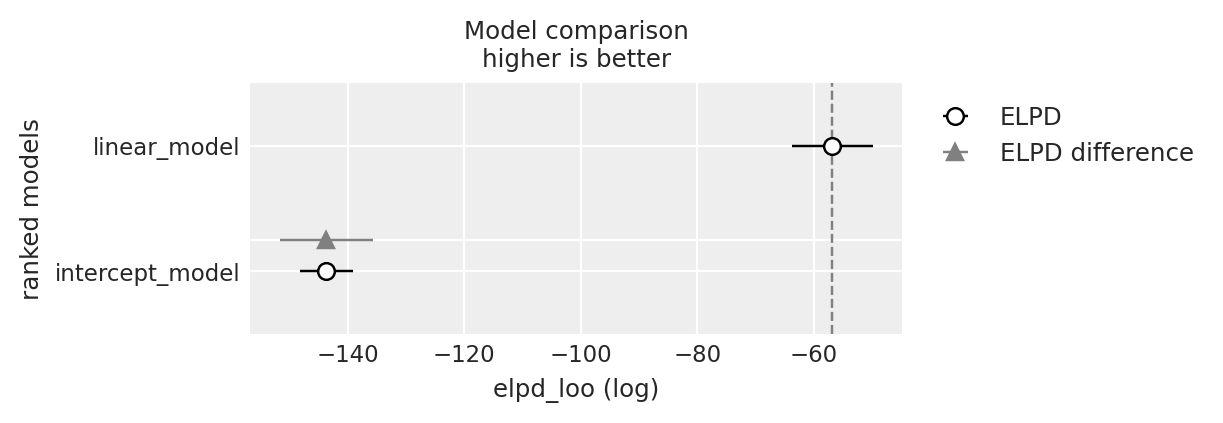

In [23]:
_ = az.plot_compare(df_comp_loo, insample_dev=False)

## Riflessioni Conclusive

In questo capitolo, abbiamo esplorato in dettaglio il metodo della Validazione Incrociata Leave-One-Out (LOO-CV) e il suo utilizzo nel framework `cmdstan`, sottolineando la sua importanza nella pratica della modellazione statistica.

Un punto centrale della discussione è stato il ruolo fondamentale della LOO-CV nel confronto tra diversi modelli. Questo metodo non solo consente di valutare la capacità predittiva di un singolo modello, ma si rivela anche indispensabile quando si tratta di scegliere il modello più adeguato tra diverse alternative. La LOO-CV fornisce infatti una base di confronto oggettiva e affidabile, permettendo di identificare il modello che meglio si adatta ai dati e che possiede la maggiore capacità di generalizzazione.

Inoltre, abbiamo approfondito l'importanza dei valori diagnostici Pareto $k$ nell'interpretazione delle stime ottenute tramite LOO-CV. Questi valori diagnostici sono cruciali per valutare l'affidabilità delle stime dell'ELPD derivate dalla LOO-CV, poiché forniscono un'indicazione sulla precisione e robustezza di queste stime. Valori di Pareto $k$ elevati possono segnalare che alcune osservazioni influenzano eccessivamente le stime, indicando possibili problemi di modellizzazione che potrebbero compromettere la validità delle conclusioni.

In sintesi, la combinazione di LOO-CV e dei valori diagnostici Pareto $k$ offre un approccio robusto e affidabile per la valutazione e selezione dei modelli statistici, garantendo che le scelte effettuate siano basate su criteri solidi e verificabili. Questo metodo si dimostra quindi essenziale non solo per valutare la qualità di un singolo modello, ma anche per assicurare che la selezione del modello ottimale sia supportata da una rigorosa analisi quantitativa.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w 

Last updated: Sat Jul 13 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

pingouin  : 0.5.4
logging   : 0.5.1.2
numpy     : 1.26.4
arviz     : 0.18.0
cmdstanpy : 1.2.3
matplotlib: 3.8.4
pandas    : 2.2.2
scipy     : 1.13.1

Watermark: 2.4.3

